### prepare a data for the model

In [1]:
#@title download datasets
import urllib
train = 'https://github.com/csaybar/DLcoursera/raw/master/Neural%20Networks%20and%20Deep%20Learning/week2/Logistic%20Regression%20as%20a%20Neural%20Network/datasets/train_catvnoncat.h5'
test = 'https://github.com/csaybar/DLcoursera/raw/master/Neural%20Networks%20and%20Deep%20Learning/week2/Logistic%20Regression%20as%20a%20Neural%20Network/datasets/test_catvnoncat.h5'
urllib.request.urlretrieve(train,'dataset/train_catvnoncat.h5')
urllib.request.urlretrieve(test,'dataset/test_catvnoncat.h5')

('dataset/test_catvnoncat.h5', <http.client.HTTPMessage at 0x2024bb5f460>)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage


In [3]:
import h5py

train_dataset = h5py.File('dataset/train_catvnoncat.h5', "r")

In [4]:
# look at the h5 file
d = np.array(train_dataset)
print(train_dataset.keys())
d = np.array(train_dataset['list_classes'][:])
d

<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>


array([b'non-cat', b'cat'], dtype='|S7')

In [5]:
def load_dataset():
    train_dataset = h5py.File('dataset/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('dataset/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(train_dataset["list_classes"][:]) # the list of classes # two class
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0])) # reshape to convert to array with the two dim..
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

the dataset containing: - a training set of m_train images labeled as cat (y=1) or non-cat (y=0) - a test set of m_test images labeled as cat or non-cat - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

#### Let's get more familiar with the dataset.

In [6]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [7]:
print(train_set_x_orig.shape)
print(train_set_y.shape) # 209 picture
print(np.sum(train_set_y[0,:]) / 100) # 72% labeld as a cat

(209, 64, 64, 3)
(1, 209)
0.72


y = [0], it's a 'non-cat' picture.


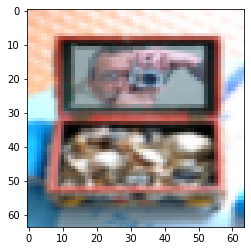

In [8]:
# Example of a picture
index = 15
plt.imshow(train_set_x_orig[index]) # like train_set_x_orig[index,:,:,:]
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

# np.squeeze(train_set_y[:, index]) to come with the Y is 1 or 0 and select the class from the classes 

In [9]:
# now we want to convert the data to a vectors to feed them to the moodel later.
# a matrix with (x,y,3) dim, we want to make it a vector with (x*y*3,1) to take the all values


# (x*y*3,1) 
print(train_set_x_orig.shape[1] * train_set_x_orig.shape[2] * train_set_x_orig.shape[3]) # (x*y*3,1) 

# the number of example
print(train_set_x_orig.shape[0]) 


# we a can use a trick the make the first dim unknown and numpy detect it.
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
print(train_set_x_flatten.shape)
print(test_set_x_flatten.shape)

12288
209
(12288, 209)
(12288, 50)


now, all data, train or test is a matrix of examles as columns and features as rows 

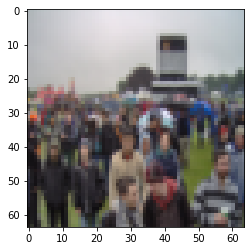

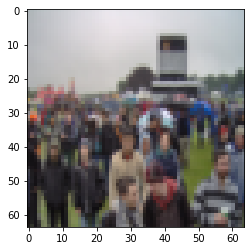

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


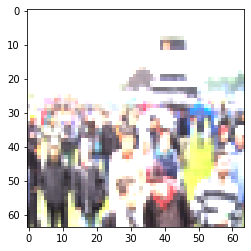

In [10]:
# one of preprocessing steps is scalling 
# we choose to scall values by diveded them by 255, the maximum value

# look
index = 100
plt.imshow(train_set_x_orig[index]) 
plt.show()
plt.imshow(train_set_x_orig[index] / 255. ) 
plt.show()

# but what about this 
plt.imshow(train_set_x_orig[index] / 100.) 


In [11]:
# scall the values
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

now, the data is ready to use in the model

## General Architecture of the learning algorithm ##

It's time to design a the model.

we will build Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

<img src="https://github.com/csaybar/DLcoursera/blob/master/Neural%20Networks%20and%20Deep%20Learning/week2/Logistic%20Regression%20as%20a%20Neural%20Network/images/LogReg_kiank.png?raw=1" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
   - Initialize the parameters of the model
   - Learn the parameters for the model by minimizing the cost.
   - update the parameters.
   - Use the learned parameters to make predictions (on the test set)
   - Analyse the results and conclude

### activation function
 - first the sigmoid function, we will use it as the activation function.
 - compute $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ to make predictions.

In [12]:
# sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    
    s = 1 /(1 + np.exp(-z))
    
    return s

In [13]:
# test
print ("sigmoid([5]) = " + str(sigmoid(5))) 

sigmoid([5]) = 0.9933071490757153


### Initializing parameters
- Initializing parameters by zeros and we will update them later

In [14]:
def inti_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    
    """
    w = np.zeros(dim).reshape(dim,1)
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int)) # 
    
    return w , b
    

In [15]:
dim = 2
w, b = inti_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


### - Forward and Backward propagation

now we can do the "forward" and "backward" propagation steps for learning the parameters ( update parameters)

Implement a function `propagate()` that computes the cost function and its gradient.


Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using to backward propagation: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [16]:
# propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T, X) + b)  # compute activation
    cost = (-1./m)*np.sum((Y*np.log(A)+(1-Y)*np.log(1-A)), axis=1) # compute cost
   
    
    # BACKWARD PROPAGATION (calculs, Derivative with respects to the parameters)
    dw = (1./m)*np.dot(X,((A-Y).T)) 
    db = (1./m)*np.sum(A-Y, axis=1)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [17]:
# small data to test
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = [0.00145558]
cost = 5.801545319394553


> now we can learn and update parameters

### Optimization
 > use the propagate function to calculate the cost funcions and gradent, then update parameters with a learning rate 

In [18]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    # update parameters .. w,b
    cost = []
    for i in range(num_iterations):
        grades , co = propagate(w, b, X, Y)
        w = w - learning_rate * grades["dw"]
        b = b - learning_rate * grades["db"]
        if print_cost == True:
            print("the cost is " + str(co))
            
        #  cost every 50 training iterations
        if print_cost and i % 100 == 0:
            cost.append(co)
     
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": grades["dw"],
             "db": grades["db"]}
    
    return params, grads, cost

In [19]:
# test last function

params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = [1.92535983]
dw = [[0.67752042]
 [1.41625495]]
db = [0.2191945]


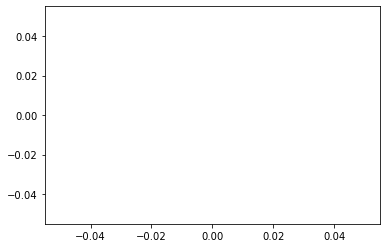

In [20]:
# print the list of costs
plt.plot(costs)

### predict 
 > now, we will build function to predict. 

In [21]:
def predict(w, b, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    
    """
    
    
    A = sigmoid(np.dot(w.T,X) + b)
    y = A > 0.5 
  #  print(type(y))
  #  print(y.shape)
    return y
    

In [22]:
# test
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[ True  True False]]


### Merge all functions into a model

In [23]:
# the model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
   
    
    # initialize parameters with zeros
    w, b = inti_zeros(X_train.shape[0])

    # Gradient descent 
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

   

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [24]:
# test the model
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 200, learning_rate = 0.005, print_cost = True)

the cost is 0.6931471805599453
the cost is 0.7410294145065183
the cost is 0.7531535818862111
the cost is 0.8667086956701202
the cost is 0.7685635006608347
the cost is 0.897014473644793
the cost is 0.7556132280568213
the cost is 0.880436642683987
the cost is 0.7514852682041282
the cost is 0.8771330533999597
the cost is 0.7449403578103343
the cost is 0.869479030571014
the cost is 0.7395380761496434
the cost is 0.8631813827864872
the cost is 0.7341140373099903
the cost is 0.8564988745006686
the cost is 0.7289883166665418
the cost is 0.8499947121719624
the cost is 0.7240300591410962
the cost is 0.843519150240876
the cost is 0.719248930310633
the cost is 0.8371297668639591
the cost is 0.7146178461453454
the cost is 0.8308196474365936
the cost is 0.7101237125685045
the cost is 0.8245968156414775
the cost is 0.7057525912197258
the cost is 0.818462789308895
the cost is 0.7014932393013826
the cost is 0.8124189543586329
the cost is 0.6973357819554409
the cost is 0.8064653562757486
the cost is 0.

> may be good with this hyperorameters.. but it is simple with little dataset and it's linear.


In [25]:
# test the model
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 200, learning_rate = 0.007, print_cost = True)

the cost is 0.6931471805599453
the cost is 0.8703030226694572
the cost is 1.1553895089980868
the cost is 1.8501225862257997
the cost is 0.6369879476939885
the cost is 0.6666017361860352
the cost is 0.8210539996907043
the cost is 1.378458256132588
the cost is 0.8574881231711966
the cost is 1.463776399907003
the cost is 0.7790778938356125
the cost is 1.292090373984189
the cost is 0.897810389115807
the cost is 1.5388560078747096
the cost is 0.7049016724643862
the cost is 1.0952350906257768
the cost is 1.0208889001020158
the cost is 1.689218059908375
the cost is 0.6131985115497758
the cost is 0.7612668741001073
the cost is 1.0486670493622519
the cost is 1.70115374516191
the cost is 0.5943361597470677
the cost is 0.7079602969544998
the cost is 0.984953019842587
the cost is 1.626463392694565
the cost is 0.6068392113678243
the cost is 0.7981875967778252
the cost is 1.046673769564775
the cost is 1.6690569103156514
the cost is 0.5781917159979352
the cost is 0.6959203385816404
the cost is 0.9606

> few dataset and few test data, with them we can see alot like this ^^

In [26]:
# test the model
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 600, learning_rate = 0.005, print_cost = True)

the cost is 0.6931471805599453
the cost is 0.7410294145065183
the cost is 0.7531535818862111
the cost is 0.8667086956701202
the cost is 0.7685635006608347
the cost is 0.897014473644793
the cost is 0.7556132280568213
the cost is 0.880436642683987
the cost is 0.7514852682041282
the cost is 0.8771330533999597
the cost is 0.7449403578103343
the cost is 0.869479030571014
the cost is 0.7395380761496434
the cost is 0.8631813827864872
the cost is 0.7341140373099903
the cost is 0.8564988745006686
the cost is 0.7289883166665418
the cost is 0.8499947121719624
the cost is 0.7240300591410962
the cost is 0.843519150240876
the cost is 0.719248930310633
the cost is 0.8371297668639591
the cost is 0.7146178461453454
the cost is 0.8308196474365936
the cost is 0.7101237125685045
the cost is 0.8245968156414775
the cost is 0.7057525912197258
the cost is 0.818462789308895
the cost is 0.7014932393013826
the cost is 0.8124189543586329
the cost is 0.6973357819554409
the cost is 0.8064653562757486
the cost is 0.

the cost is 0.4016993977414896
the cost is 0.40436608100490595
the cost is 0.3999693859915879
the cost is 0.4024187153377506
the cost is 0.39825327496014956
the cost is 0.4004938495102034
the cost is 0.39655153346691674
the cost is 0.3985919374096682
the cost is 0.3948646613314855
the cost is 0.3967134616312998
the cost is 0.39319319010318415
the cost is 0.3948589334050029
the cost is 0.3915376835655915
the cost is 0.3930288921983388
the cost is 0.3898987379567916
the cost is 0.3912239049313531
the cost is 0.3882769818386256
the cost is 0.38944456473307154
the cost is 0.38667307554038094
the cost is 0.38769148916375384
the cost is 0.3850877100948939
the cost is 0.38596531782241084
the cost is 0.38352160557840576
the cost is 0.3842667092561593
the cost is 0.38197550876031094
the cost is 0.38259633708737956
the cost is 0.3804501899658872
the cost is 0.3809548852771572
the cost is 0.3789464390550751
the cost is 0.379343042450011
the cost is 0.37746506042437517
the cost is 0.37776149521638

the cost is 0.28967370627326217
the cost is 0.2894428890718248
the cost is 0.2892124699418256
the cost is 0.28898244772169246
the cost is 0.28875282125482754
the cost is 0.2885235893895782
the cost is 0.2882947509792083
the cost is 0.28806630488187074
the cost is 0.2878382499605783
the cost is 0.2876105850831762
the cost is 0.28738330912231425
the cost is 0.2871564209554198
the cost is 0.28692991946466984
the cost is 0.286703803536964
the cost is 0.2864780720638982
the cost is 0.28625272394173734
the cost is 0.2860277580713893
the cost is 0.28580317335837796
the cost is 0.2855789687128181
the cost is 0.2853551430493887
the cost is 0.2851316952873076
the cost is 0.28490862435030545
the cost is 0.28468592916660157
the cost is 0.28446360866887715
the cost is 0.2842416617942518
the cost is 0.28402008748425767
the cost is 0.28379888468481546
the cost is 0.28357805234620975
the cost is 0.2833575894230648
the cost is 0.2831374948743206
the cost is 0.28291776766320836
the cost is 0.28269840675

> face a problems with it's simplicity

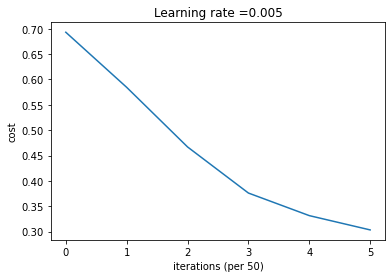

In [27]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per 50)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()